In [10]:
import pandas as pd
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from modelling import plot_loss_accuracy_curves
from PIL import Image
import random

In [2]:
data_dir = "..\\..\\DATA\\HAM10000_images_part_1_and_2"  # directory with all images

In [3]:
dest_dir = "..\\..\\DATA\\recognized\\"  # directory where all images will be divided into subdirectories

# Load data and train test split

In [4]:
df = pd.read_csv("..\\..\\DATA\\HAM10000_metadata")  # read metadata

In [5]:
df = df.rename(columns={"dx": "diagnosis"})
df = df[["image_id", "diagnosis"]]

In [6]:
train_dir = os.path.join(dest_dir, "train")  # create train directory
test_dir = os.path.join(dest_dir, "test")  # create test directory
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [27]:
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["diagnosis"], random_state=42
)  # split images into test and train directories

In [28]:
for index, row in train_df.iterrows():
    source_file = os.path.join(data_dir, row["image_id"] + ".jpg")
    destination_file = os.path.join(
        train_dir, row["diagnosis"], f"{row['image_id']}.jpg"
    )
    os.makedirs(os.path.dirname(destination_file), exist_ok=True)
    shutil.copyfile(
        source_file, destination_file
    )  # create subdirectories for each label inside train directory

In [12]:
def display_random_images_from_category(category_dir, category_name, num_images=5):
    image_files = random.sample(os.listdir(category_dir), num_images)
    plt.figure(figsize=(20, 4))
    for i, image_file in enumerate(image_files):
        img = Image.open(os.path.join(category_dir, image_file))
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"{category_name} {i+1}")
        plt.axis('off')
    plt.show()

Random example images from 'nv' category:


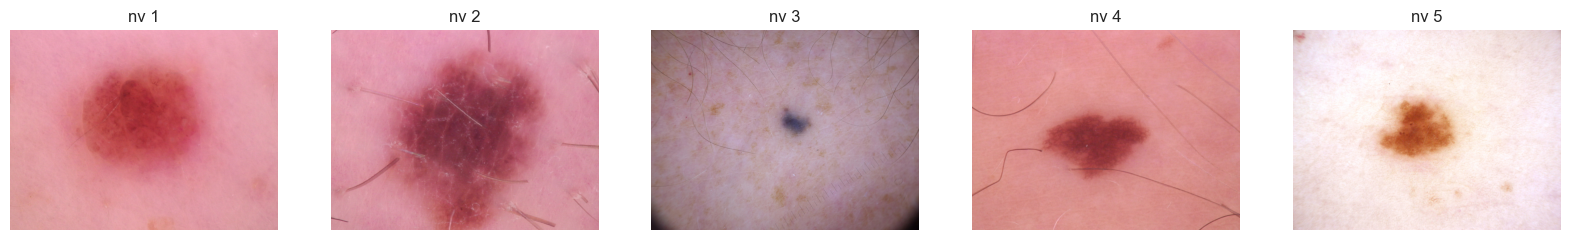

Random example images from 'mel' category:


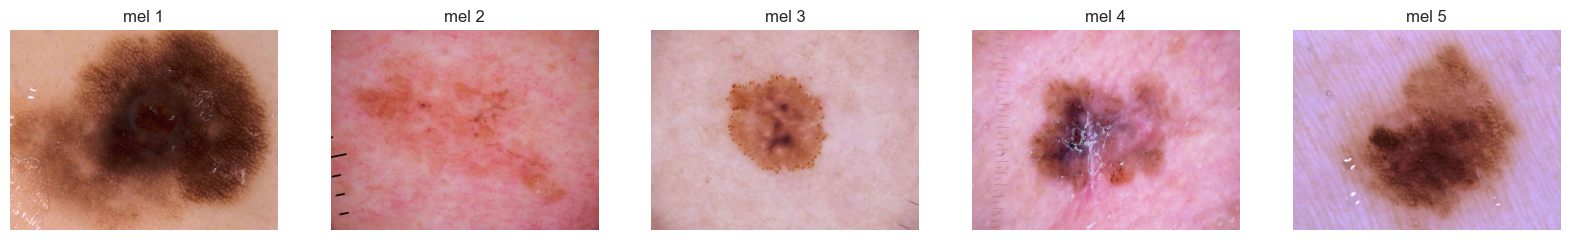

In [18]:
# Directories for 'nv' and 'mel' images in the train dataset
nv_dir = os.path.join(train_dir, "nv")
mel_dir = os.path.join(train_dir, "mel")

# Display 5 random example images from 'nv' category
print("Random example images from 'nv' category:")
display_random_images_from_category(nv_dir, 'nv')

# Display 5 random example images from 'mel' category
print("Random example images from 'mel' category:")
display_random_images_from_category(mel_dir, 'mel')

In [29]:
for index, row in test_df.iterrows():
    source_file = os.path.join(data_dir, row["image_id"] + ".jpg")
    destination_file = os.path.join(
        test_dir, row["diagnosis"], f"{row['image_id']}.jpg"
    )
    os.makedirs(os.path.dirname(destination_file), exist_ok=True)
    shutil.copyfile(
        source_file, destination_file
    )  # create subdirectories for each label inside test directory

# Data augmentation and data flowing from data directory

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    vertical_flip=True,
    fill_mode="reflect",
)  # define train image generator, add data augmentation techniques

In [31]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # define test image generator

In [32]:
train_data = train_datagen.flow_from_directory(
    directory=train_dir, class_mode="categorical", batch_size=32, target_size=(128, 128)
)  # load train data

Found 8012 images belonging to 7 classes.


In [33]:
test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode="categorical",
    batch_size=32,
    target_size=(128, 128),
    shuffle=False,
)  # load test data

Found 2003 images belonging to 7 classes.


# Defining and training first model

In [34]:
tf.random.set_seed(42)  # define global random seed as 42

In [35]:
model_1 = Sequential(
    [
        Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(128, 128, 3)),
        Conv2D(10, 3, activation="relu"),
        MaxPool2D(pool_size=2, padding="valid"),
        Conv2D(10, 3, activation="relu"),
        Conv2D(10, 3, activation="relu"),
        MaxPool2D(2),
        Flatten(),
        Dense(7, activation="softmax"),
    ]
)

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [36]:
model_1.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [37]:
history_1 = model_1.fit(train_data, epochs=5, validation_data=test_data)

Epoch 1/5


C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 154s 593ms/step - accuracy: 0.6540 - loss: 1.1587 - val_accuracy: 0.6690 - val_loss: 0.9804
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 132s 519ms/step - accuracy: 0.6536 - loss: 1.0045 - val_accuracy: 0.6680 - val_loss: 0.9785
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 191s 755ms/step - accuracy: 0.6677 - loss: 0.9595 - val_accuracy: 0.6725 - val_loss: 0.9339
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 221s 865ms/step - accuracy: 0.6681 - loss: 0.9307 - val_accuracy: 0.6655 - val_loss: 0.9251
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 238s 925ms/step - accuracy: 0.6609 - loss: 0.9041 - val_accuracy: 0.6715 - val_loss: 0.8948


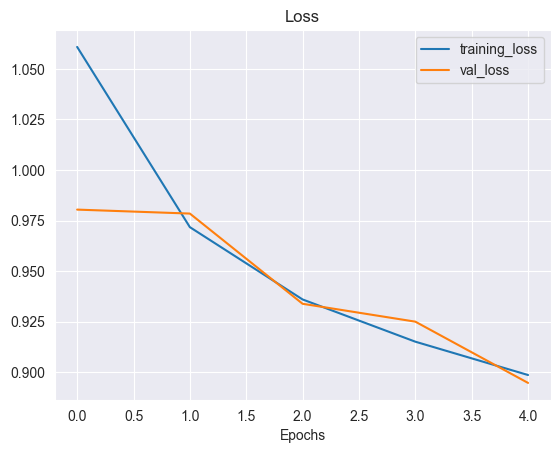

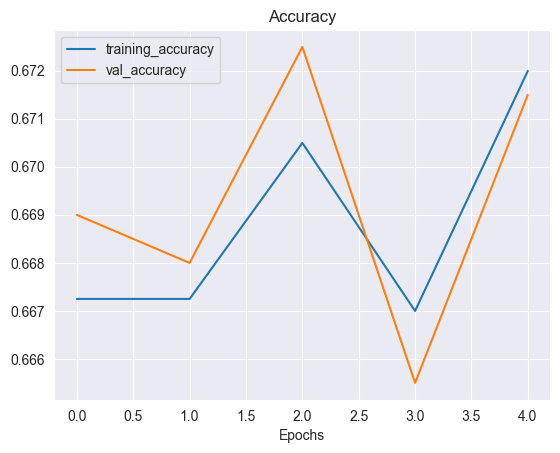

In [38]:
plot_loss_accuracy_curves(history_1)

Extremely high accuracy at the beginning -> issue connected with imbalanced dataset

In [39]:
class_names = list(train_data.class_indices.keys())

In [40]:
y_test = test_data.classes  # true values

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step


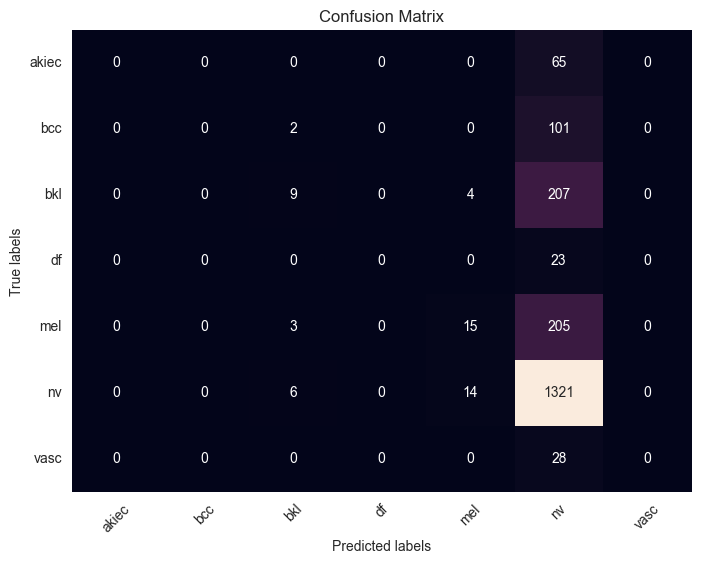

In [43]:
y_predict = model_1.predict(test_data)  # predict values based on test data

preds = np.argmax(y_predict, axis=1)

confusion_matrix = tf.math.confusion_matrix(y_true, preds)  # get confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cbar=False)

plt.xticks(
    ticks=np.arange(len(class_names)) + 0.5,
    labels=class_names,
    rotation=45,
    ha="center",
)
plt.yticks(
    ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0, va="center"
)

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [44]:
print(classification_report(y_test, preds, target_names=class_names))

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       0.00      0.00      0.00       103
         bkl       0.45      0.04      0.07       220
          df       0.00      0.00      0.00        23
         mel       0.45      0.07      0.12       223
          nv       0.68      0.99      0.80      1341
        vasc       0.00      0.00      0.00        28

    accuracy                           0.67      2003
   macro avg       0.23      0.16      0.14      2003
weighted avg       0.55      0.67      0.56      2003


C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

# Train model with added class weights

In [22]:
class_weights = class_weight.compute_class_weight(
    "balanced", classes=np.unique(train_data.classes), y=train_data.classes
)  # compute class weights for each

In [23]:
class_weights_dict = dict(enumerate(class_weights))

In [24]:
model_2 = tf.keras.models.clone_model(model_1)  # clone model_1's architecture

In [25]:
model_2.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [26]:
history_2 = model_2.fit(
    train_data, epochs=5, validation_data=test_data, class_weight=class_weights_dict
)

Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 200s 775ms/step - accuracy: 0.2654 - loss: 2.1024 - val_accuracy: 0.3210 - val_loss: 1.7392
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 208s 816ms/step - accuracy: 0.3516 - loss: 1.7917 - val_accuracy: 0.4758 - val_loss: 1.4432
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 187s 725ms/step - accuracy: 0.2504 - loss: 1.7931 - val_accuracy: 0.4828 - val_loss: 1.4951
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 187s 729ms/step - accuracy: 0.3426 - loss: 1.7708 - val_accuracy: 0.1323 - val_loss: 1.8253
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 185s 722ms/step - accuracy: 0.3054 - loss: 1.8111 - val_accuracy: 0.1518 - val_loss: 1.8498


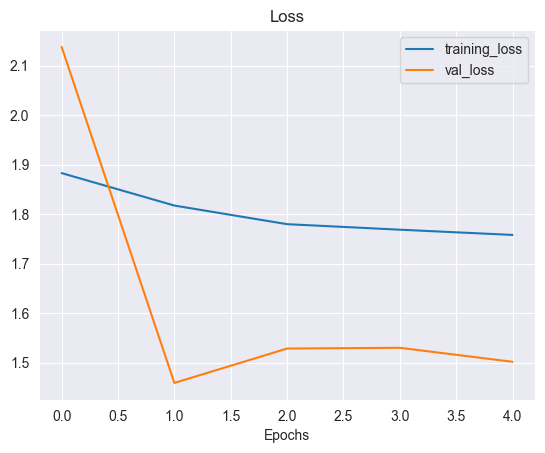

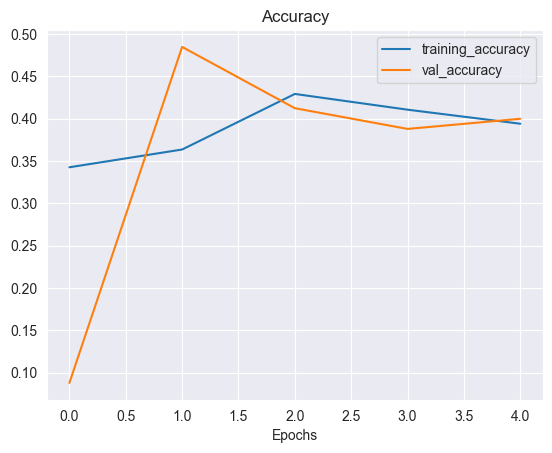

In [103]:
plot_loss_accuracy_curves(history_2)

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 247ms/step


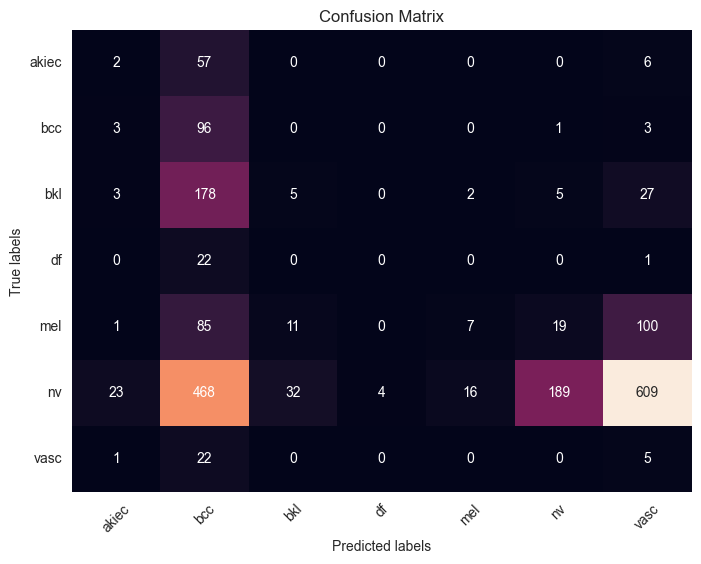

In [27]:
y_predict = model_2.predict(test_data)

preds = np.argmax(y_predict, axis=1)

confusion_matrix = tf.math.confusion_matrix(y_test, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cbar=False)

plt.xticks(
    ticks=np.arange(len(class_names)) + 0.5,
    labels=class_names,
    rotation=45,
    ha="center",
)
plt.yticks(
    ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0, va="center"
)

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [28]:
print(classification_report(y_test, preds, target_names=class_names))

              precision    recall  f1-score   support

       akiec       0.06      0.03      0.04        65
         bcc       0.10      0.93      0.19       103
         bkl       0.10      0.02      0.04       220
          df       0.00      0.00      0.00        23
         mel       0.28      0.03      0.06       223
          nv       0.88      0.14      0.24      1341
        vasc       0.01      0.18      0.01        28

    accuracy                           0.15      2003
   macro avg       0.21      0.19      0.08      2003
weighted avg       0.64      0.15      0.18      2003


extremely low accuracy

# Dataset imbalance

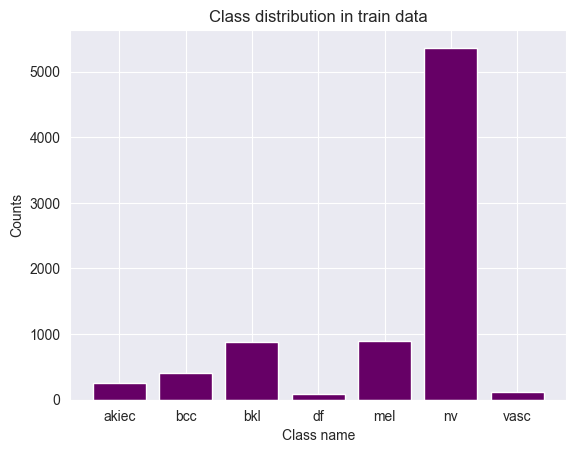

In [45]:
unique, counts = np.unique(np.array(list(train_data.classes)), return_counts=True)
plt.bar(x=class_names, height=counts, color="#660066")
plt.title("Class distribution in train data")
plt.xlabel("Class name")
plt.ylabel("Counts");

In [46]:
counts

array([ 262,  411,  879,   92,  890, 5364,  114], dtype=int64)

Next strategy -> Balance dataset